In [11]:
#importing stuff
from io import StringIO
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

In [12]:
sample_rate = 32 #Hz
sensor_min = -1.5 * 9.8 #g
sensor_max =  1.5 * 9.8 #g
sample_res = 63

def normalData(_data):
    data = sensor_min + (_data/sample_res) * (sensor_max - sensor_min)
    return data

In [13]:
#%ls HMP_Dataset/Walk/
def parseAdlTxt(file):
    s = "HMP_Dataset/Walk/Accelerometer-2011-03-24-09-51-07-walk-f1.txt"
    data = np.genfromtxt(s, dtype=np.float32, delimiter=" ")
    #normalize data here
    return data

In [14]:
def getRecordsFromTxt(folderPath):
    for root, dirs, files in os.walk(folderPath, topdown=False):
#         print(root)
#         print(dirs)
        prev_shape = None
        records = [] #append a list
        for name in files:
            data = normalData(parseAdlTxt(os.path.join(root, name)))

            if(prev_shape != None and prev_shape != data.shape):
                print("Error: data sample length not uniform")
                exit(-1)
            else:
                prev_shape = data.shape

            records.append(data)
            #print(name, data.shape)
    return records

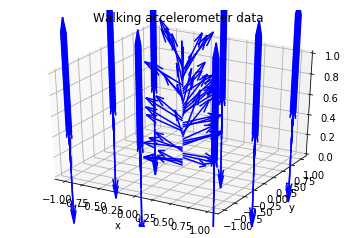

In [26]:
plot_start_samples = 150
plot_end_samples = 300
filter_window = 5
display_sample = 50


records = getRecordsFromTxt("HMP_Dataset/Walk/")
data = records[1]
data = data[plot_start_samples:plot_end_samples] #crop

x = np.linspace(-1,1,3)
y = np.linspace(-1,1,3)
# x = np.zeros([plot_samples])
# y = np.zeros([plot_samples])
z = np.linspace(0,1, display_sample)

x,y,z = np.meshgrid(x,y,z)

fig = plt.figure()
ax = fig.gca(projection='3d')

data = np.swapaxes(data, 0, 1)
[bx, by, bz] = data
bx = bx - np.mean(bx)
by = by - np.mean(by)
bz = bz - np.mean(bz)

bx = sp.signal.medfilt(bx,filter_window)
by = sp.signal.medfilt(by,filter_window)
bz = sp.signal.medfilt(bz,filter_window)

bx = sp.signal.resample(bx, display_sample)
by = sp.signal.resample(by, display_sample)
bz = sp.signal.resample(bz, display_sample)

#normalize sample-z for plotting
z_min = np.min(bz)
z_max = np.max(bz)
z_norm_factor = 1 / (z_max - z_min) / 4

u = np.zeros([3,3, display_sample])
v = np.zeros([3,3, display_sample])

u[1,1,:] = bx
v[1,1,:] = by
bz = (bz * z_norm_factor) + z
#bz = 0

ax.quiver(x,y,z,u,v,bz,color='b',length=0.5,normalize=True)
plt.title('Walking accelerometer data')
plt.xlabel('x')
plt.ylabel('y')

plt.show()